# Classifiers using neuro-imaging data

In [17]:
import pandas as pd
import numpy as np
from numpy import random, arange
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import balanced_accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OrdinalEncoder, PolynomialFeatures, LabelEncoder

# Import relevant sklearn classes related to machine learning models
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, ElasticNet
from sklearn.svm import SVC, SVR, NuSVC
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.neural_network import MLPClassifier

# Import relevant sklearn class/function related to evaluation
import sklearn.metrics
from imblearn.under_sampling import RandomUnderSampler

#Smote oversampling 
import smote_variants as sv

## Data Pre-Processing

In [24]:

img_adni1 = pd.read_csv("../data/UCSFFSX51_ADNI1_3T_02_01_16.csv", low_memory=False)
img_adni2 = pd.read_csv("../data/UCSFFSX51_11_08_19.csv", low_memory=False)
img_adni3 = pd.read_csv("../data/UCSFFSX6_08_17_22.csv", low_memory=False)
adni_merge= pd.read_csv('../data/ADNIMERGE.csv', low_memory=False)


In [25]:

img_adni2.drop(["LONISID", "IMAGETYPE", "LHIPQC", "RHIPQC", "ST131HS", "ST132HS", "ST133HS", "ST134HS", "ST135HS", "ST136HS", "ST137HS", "ST138HS", "ST139HS", "ST140HS", "ST141HS", "ST142HS", "ST143HS", "ST144HS", "ST145HS", "ST146HS"], inplace=True, axis=1)
img_adni3.drop(["HIPPOQC"], axis=1, inplace=True)

In [26]:
colNames2 = []
for colName2 in img_adni2.columns:
    if not colName2 in img_adni1.columns:
        #print(colName2)
        if not (colName2 == "VISCODE2" or colName2 =="COLPROT"):
            colNames2.append(colName2)

print("---")
for colName3 in img_adni3.columns:
    if not colName3 in img_adni2.columns:
        print(colName3)
print("---")
colNames = []
for colName1 in img_adni1.columns:
    if not colName1 in img_adni2.columns:
        #print(colName1)
        colNames.append(colName1)


img_adni1.drop(colNames, inplace=True, axis=1)
img_adni2.drop(colNames2, inplace=True, axis=1)
img_adni3.drop(colNames2, axis=1, inplace=True)

---
---


In [27]:
dx = pd.read_csv("../data/DXSUM_PDXCONV_ADNIALL.csv", low_memory=False)
dx2= dx[(dx["Phase"] == "ADNI2") | (dx["Phase"] == "ADNIGO")]


In [28]:
len(img_adni2)

4896

In [29]:

test = pd.merge(img_adni2, dx2[["VISCODE2", "RID", "DXCHANGE", "Phase"]], left_on=["VISCODE2","RID", "COLPROT"], right_on=["VISCODE2","RID", "Phase"])

In [30]:
len(test)

2701

In [13]:
test.head()

,RID,VISCODE,VISCODE2,EXAMDATE,VERSION,LONIUID,IMAGEUID,RUNDATE,STATUS,OVERALLQC,...,ST148SV,ST149SV,ST150SV,ST151SV,ST152SV,ST153SV,ST154SV,ST155SV,update_stamp,DXCHANGE
0,21,v11,m84,2012-10-04,2012-10-24,169744.0,340931,2012-10-24,complete,Pass,...,193489.0,384420.0,196942.0,197448.0,394390.0,142785.0,527205.0,869951.0,2019-11-14 14:34:00.0,1.0
1,21,nv,m60,2010-10-08,2012-02-10,93190.0,222684,2012-02-10,complete,Pass,...,193313.0,384534.0,205140.0,204958.0,410098.0,146962.0,531496.0,885815.0,2019-11-14 14:34:00.0,1.0
2,21,nv,m60,2010-10-08,2012-02-10,93187.0,222738,2012-02-10,partial,Pass,...,188826.0,375077.0,210619.0,208063.0,418682.0,146446.0,521523.0,883558.0,2019-11-14 14:34:00.0,1.0
3,21,v06,m72,2011-10-13,2012-04-05,125206.0,265250,2012-04-05,complete,Pass,...,184681.0,366238.0,208414.0,209070.0,417484.0,144658.0,510896.0,877214.0,2019-11-14 14:34:00.0,1.0
4,21,v21,m96,2013-10-17,2013-12-23,204109.0,398269,2013-12-23,partial,Partial,...,189780.0,373956.0,200248.0,198403.0,398652.0,141727.0,515683.0,860546.0,2019-11-14 14:34:00.0,1.0


<AxesSubplot:xlabel='DXCHANGE', ylabel='Probability'>

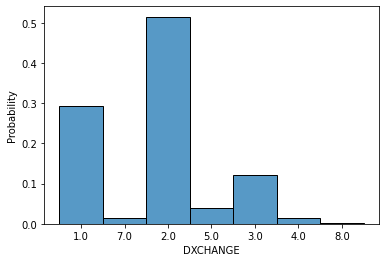

In [15]:

sns.histplot(test['DXCHANGE'].astype(str), stat='probability')

In [45]:
len(img_adni2)

4896

In [40]:
3990 + 4948 + 2646

11584

In [41]:
len(adni_merge)

16222